# Lambda toy examples on measurement error (ME)

- Error only in the outcome Ex, predictors are measured without error
- Ex is measured (or estimated) with substantial error
- Thos errors can be reported as
    - Standard errors
    - Probabilities associated with each of the estimates
    - Any model about how the estimates were generated
    - Distribution of estimates (independently on their probabilities)

**The goal is incorportate that information when modeling the relation between Ex and GDP. For now, we assume that the model is specified correctly (no model uncertainty).**

Here a simple diagram of the toy model: 

![](model_error_diagram.png)

1. Ex_obs is a descendent of Ex (true value), so there is no bias introduced
2. The later isn't necessarily true (measurement error varies across countries in ways that might be associated with the variable of interest, GDP)
3. We don't have the true value Ex, but each Ex_obs can be a function of `normal(Ex, Ex_se)`, so that we can define the probability of each country-year's observed `Ex_se` by using Bayesian updating
4. There should be shrinkage (uncertainty of measurement influences the regression parameters in the linear model, and the regression parameters influence the uncertainty in measurements) 

Assuming estimates (N and values) provide sensible standard desviation values (this probably is not the case):

- I compute the standard desviation using the estimates available (Ex) by country and year
- The observed value is defined as (1) the mean of estimates by country and year, or (2) a random value
- I impute GDP missing data, and SD when there is only one estimate

In [325]:
# read data
library(data.table); library(haven); library(zoo); library(texreg); library(brms)
set.seed(150720)
source("utils.R")
dat = data.table(read_stata("../data/Ex-LA1850-2020-estimates.dta"))

In [326]:
# estimate standard error based on estimates, just to create the example
dat = dat[age == 0 & sex == 1]
sdat = dat[, .(ex_obs_mean = mean(Ex), ex_obs_random = as.numeric(sample(Ex, size = 1)), sd_ex = sd(Ex), N = .N, gdp = getMin(gdp_pc)), .(ctry, myear)]

# impute standard error NA (one observation with the min standard error by country, just to remove missing values)
setorder(sdat, ctry, myear)
sdat[, sd_ex := ifelse(is.na(sd_ex), mean(sd_ex, na.rm = TRUE), sd_ex), ctry]
sdat[, igdp := fillMissingForwardBackward(gdp), ctry]

# log of variables
sdat[, log_gdp := log(igdp)][, log_sd_ex := log(sd_ex)]

# center variables
vars = c("log_gdp", "myear")
sdat[, (vars) := lapply(.SD, scale, scale = FALSE), .SDcols = vars]

In [327]:
print(head(sdat))

   ctry     myear ex_obs_mean ex_obs_random     sd_ex  N    gdp   igdp
1: 2020 -91.19718    51.81353      31.59291 14.742584 21 2388.0 2388.0
2: 2020 -56.19718    46.40589      58.87268 12.051465 13 3191.0 3191.0
3: 2020 -46.19718    46.98195      35.35555  8.020920 17 3302.0 3302.0
4: 2020 -36.19718    46.82778      12.00000  5.374849  1 3956.5 3956.5
5: 2020 -26.19718    54.88960      34.00000 12.051960 12 4080.0 4080.0
6: 2020 -16.19718    63.90581      80.63255  9.329050 17 5089.0 5089.0
      log_gdp log_sd_ex
1: -0.1029641  2.690740
2:  0.1869140  2.489186
3:  0.2211080  2.082053
4:  0.4019395  1.681730
5:  0.4326766  2.489227
6:  0.6536610  2.233133


[1] -0.6051385

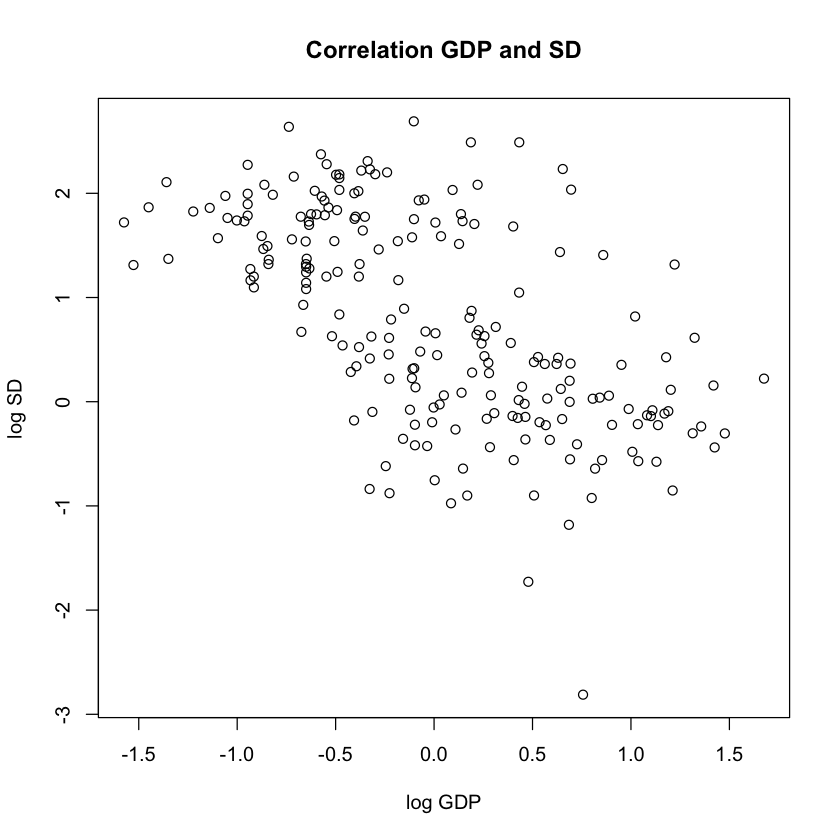

In [328]:
# correlation between SD and gpd
plot(sdat$log_gdp,sdat$log_sd_ex, xlab = "log GDP", ylab = "log SD", main = "Correlation GDP and SD")
# countries with higher GDP have less variability in estimates, so the toy model is mis-specified
cor(sdat$log_gdp,sdat$log_sd_ex)

# Models

In [329]:
# Ex average of estimates by country and year
m1 = brm(ex_obs_mean ~ log_gdp + myear + (1 | ctry), family = gaussian, data = sdat)
# measurement error model
m2 = brm(ex_obs_mean | mi(sd_ex) ~ log_gdp + myear + (1|ctry), family = gaussian, data = sdat, save_mevars = TRUE)
# Ex random value of estimates by country and year
m3 = brm(ex_obs_random ~ log_gdp + myear + (1 | ctry), family = gaussian, data = sdat)
# measurement error model
m4 = brm(ex_obs_random | mi(sd_ex) ~ log_gdp + myear + (1|ctry), family = gaussian, data = sdat, save_mevars = TRUE)

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling




SAMPLING FOR MODEL '4897d70e6caef199781532e428546884' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000173 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.73 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.442699 seconds (Warm-up)
Chain 1:                0.308215 seconds (Sampling)

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling




SAMPLING FOR MODEL '5fc5b1cc1fe871eaf172e2f6565d6967' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 6.6e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 2.53645 seconds (Warm-up)
Chain 1:                0.957898 seconds (Sampling)
C

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling




SAMPLING FOR MODEL '4897d70e6caef199781532e428546884' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 5.1e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.44892 seconds (Warm-up)
Chain 1:                0.271953 seconds (Sampling)
C

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling




SAMPLING FOR MODEL '5fc5b1cc1fe871eaf172e2f6565d6967' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 7e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.9042 seconds (Warm-up)
Chain 1:                0.49344 seconds (Sampling)
Chain 

In [330]:
custom.model.names = c("Ex avg", "Ex avg + ME", "Ex random", "Ex random + ME")
cat(
    screenreg(list(m1, m2, m3, m4), include.r2 = FALSE, include.loo = FALSE, 
    custom.model.names = custom.model.names)
   )


                 Ex avg          Ex avg + ME     Ex random       Ex random + ME
-------------------------------------------------------------------------------
Intercept         52.26 *         52.91 *         51.07 *         51.36 *      
                 [50.17; 54.41]  [50.89; 55.00]  [48.69; 53.55]  [48.99; 53.66]
log_gdp            7.10 *          4.14 *          5.89 *          4.25 *      
                 [ 4.52;  9.68]  [ 2.12;  6.18]  [ 2.34;  9.13]  [ 1.14;  7.27]
myear              0.27 *          0.32 *          0.32 *          0.35 *      
                 [ 0.23;  0.31]  [ 0.29;  0.35]  [ 0.26;  0.38]  [ 0.30;  0.41]
sd(Intercept)      4.38 *          4.21 *          4.65 *          4.48 *      
                 [ 2.94;  6.45]  [ 2.89;  6.17]  [ 2.85;  7.27]  [ 2.85;  6.77]
-------------------------------------------------------------------------------
Num. obs.        213             213             213             213           
Num. obs.  ctry   19              19   

- Using models that takes measurement error into account, reduces the point estimates of the `log_gdp` coefficient, although differences between the estimates across models are not that systematic (overlap of CIs)
- That seems to be because countries with low gdp tend to also have more uncertain Ex estimates, those estimates have been shrunk towards the expected mean defined by the regression line of the values with less uncertainty